In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
if 1:
  !pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.8 MB 1.1 MB/s 


In [4]:
if 1:
  !pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 4.2 MB/s 


In [2]:
import sys
import pathlib
import numpy as np
import pandas as pd
import dask.dataframe as dd
from dask.distributed import Client, wait
from scipy.spatial.distance import cdist
from mpl_toolkits.mplot3d.axes3d import Axes3D
import pylab
from scipy import stats
import random
# Кластеризация
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.neighbors import KNeighborsClassifier
# Понижения размерности
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
#from auxiliary import trim_memory
#from telecom.transformers import ColumnsCorrector
from sklearn.pipeline import make_pipeline
from sklearn.utils.class_weight import compute_class_weight
from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score,\
                learning_curve
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.feature_selection import RFE
#from lightgbm import LGBMClassifier
import catboost as catb
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [4]:
import shap

# load JS visualization code to notebook
shap.initjs()

# В связи с тем, что работал в разных аккаунтах Гугл Коллаба, пришлось оставить функции внутри ноутбука.

In [5]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))
    
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)
    
def balance_df_by_target(df, target_name, method='over'):

    assert method in ['over', 'under', 'tomek', 'smote'], 'Неверный метод сэмплирования'
    
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    if method == 'over':
        for i in range(disbalance_coeff):
            sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
            df = df.append(sample, ignore_index=True)
            
    elif method == 'under':
        df_ = df.copy()
        df = df_[df_[target_name] == minor_class_name]
        tmp = df_[df_[target_name] == major_class_name]
        df = df.append(tmp.iloc[
            np.random.randint(0, tmp.shape[0], target_counts[minor_class_name])
        ], ignore_index=True)

    elif method == 'tomek':
        from imblearn.under_sampling import TomekLinks
        tl = TomekLinks()
        X_tomek, y_tomek = tl.fit_sample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_tomek, y_tomek], axis=1)
    
    elif method == 'smote':
        from imblearn.over_sampling import SMOTE
        smote = SMOTE()
        X_smote, y_smote = smote.fit_sample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_smote, y_smote], axis=1)

    return df.sample(frac=1) 

def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [6]:
def choise_features(X_train, X_test, y_train, y_testdata, cat_feats):
    #X = data.drop(columns=['target'])
    #y = data['target']
    #X_train, X_test, y_train, y_test = train_test_split(X, y, 
    #                                                    shuffle=True,
    #                                                    test_size=0.3,
    #                                                random_state=21,
    #                                                stratify=y)

    display(y_train.value_counts(normalize=True), y_test.value_counts(normalize=True))
    disbalance = y_train.value_counts()[0] / y_train.value_counts()[1]
    frozen_params = {
     'class_weights':[1, disbalance], 
     'silent':True,
     'random_state':21,
     'cat_features': cat_feats,
     'eval_metric':'TotalF1',
     'early_stopping_rounds':40
    }    

    model_catb = catb.CatBoostClassifier(**frozen_params, iterations=300, max_depth=5)
    model_catb.fit(X_train, y_train, plot=True, eval_set=(X_test, y_test))
    evaluate_preds(model_catb, X_train, X_test, y_train, y_test)
    feature_importances = pd.DataFrame(zip(X_train.columns, model_catb.feature_importances_), 
                                       columns=['feature_name', 'importance'])
    feature_importances.sort_values(by='importance', ascending=False)

    return feature_importances

In [7]:
def reduce_mem_usage(df):
    import numpy as np
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2 # подсчитываем память потребляемую изначальным           #датасетом
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns: # проходимся по всем колонкам
        col_type = df[col].dtype  # узнаем тип колонки
        
        if col_type != object:
            c_min = df[col].min() # смотрим минимальное значение признака
            c_max = df[col].max() # смотрим максимальное значение признака
            if str(col_type)[:3] == 'int':  # if int
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max: # сравниваем с          #int8
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max: # сравниваем с      #int16 и.т.д.
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else: # если был тип object, то меняем его тип на пандасовский тип 'category', на нем разные       #агрегации данных работают в разы быстрее
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2  # считаем сколько теперь у нас занято памяти
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))  # и выводим статистику
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [ ]:
!ls

catboost_info	   data			  eda_before_merge.ipynb  __pycache__
dask-worker-space  eda_after_merge.ipynb  models		  utils.py


In [10]:
if 0:
    cwd = pathlib.Path().cwd()
    sys.path.append(cwd.as_posix())
    data_folder = cwd.joinpath('data')
    model_folder = cwd.joinpath('models')

## Загрузка и соединение исходных данных с помощью dask

In [11]:
if 0:
    data_train = pd.read_csv(data_folder.joinpath('data_train.csv')).drop('Unnamed: 0', axis=1)

In [ ]:
if 0:
    # set parameters
    blocksize = '300MB'         # 300MB per chunk
    drop_feats = ['75', '81', '85', '139', '203']

    features = dd.read_csv(data_folder.joinpath('features.csv'), blocksize=blocksize, sep='\t')\
          .drop(['Unnamed: 0', *drop_feats], axis=1)

In [ ]:
if 0:
    features_train = features.loc[features['id'].isin(data_train['id'])].compute()

In [ ]:
if 0:
    dublicated = features_train[features_train['id'].duplicated(keep=False)]\
                                  .sort_values(by='id')['id'].value_counts()

In [ ]:
if 0:
    dublicated

In [ ]:
if 0:
    features_train = features_train.sort_values(by='buy_time')
    data_train = data_train.rename(columns={'buy_time': 'buy_time_train'})
    data_train = data_train.sort_values(by='buy_time_train')
    data_train.shape

соединяю по дате предложения, сделанной позже чем регистрация абонента.

In [ ]:
if 0:
    data_merged_train = pd.merge_asof(data_train, features_train, by='id',\
            left_on='buy_time_train', right_on='buy_time', direction='backward')
    data_merged_train.head()

In [ ]:
if 0:
    data_merged_train.shape

In [ ]:
if 0:
    data_merged_train['buy_time'].isna().sum()

In [ ]:
if 0:
    data_merged_train.dropna().shape

In [ ]:
if 0:
    data_merged_train.dropna().isna().sum().sum()

In [ ]:
if 0:
    data_merged_train_res = data_merged_train.dropna()
    data_merged_train_res['time_delta'] = data_merged_train_res['buy_time_train'] - \
           data_merged_train_res['buy_time']
    data_merged_train_res['time_delta'].value_counts()

In [ ]:
if 0:
    data_merged_train_res.to_csv(data_folder.joinpath('merged_train.csv'), index=False)

In [ ]:
if 0:
    df_all = pd.read_csv(data_folder.joinpath('merged_train.csv'))

In [12]:
if 1:
    df_all = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ML_MEGAFON_CW/merged_train.csv')

In [14]:
df_all.head()

,Unnamed: 0,id,vas_id,buy_time_train,target,buy_time,0,1,2,3,...,244,245,246,247,248,249,250,251,252,time_delta
0,23,3532789,1.0,1531083600,0.0,1.531084e+09,-30.349971,-139.569112,-44.290786,-192.176798,...,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0,0.0
1,101,167964,4.0,1531083600,0.0,1.531084e+09,280.330029,47.670888,266.389214,-4.936798,...,-613.770792,-25.996269,-37.630448,-237.747724,-20.832889,-0.694428,-7.175933,-0.45614,0.0,0.0
2,151,4236220,1.0,1531083600,0.0,1.531084e+09,-96.799971,49.440888,-110.740786,-3.166798,...,-539.770792,-25.996269,-37.630448,-290.747724,-25.832889,-0.694428,-12.175933,-0.45614,1.0,0.0
3,192,3883492,4.0,1531083600,0.0,1.531084e+09,-92.139971,-46.319112,-106.080786,61.243202,...,-613.770792,-24.996269,-37.630448,1699.252276,-20.832889,1.305572,-9.175933,-0.45614,1.0,0.0
4,250,2847225,1.0,1531083600,0.0,1.531084e+09,464.210029,428.250888,450.269214,375.643202,...,6258.229208,-18.996269,58.369552,1.252276,-25.832889,-0.694428,-12.175933,-0.45614,0.0,0.0


In [15]:
df_all = df_all.drop(columns=['Unnamed: 0'])

# Exploratory data analysis

In [16]:
df_all.target.value_counts(normalize=True)

0.0    0.909252
1.0    0.090748
Name: target, dtype: float64

In [17]:
df_all = df_all[[c for c
        in list(df_all)
        if len(df_all[c].unique()) > 1]] #Перезаписываем датасет, оставляя 
#только те колонки, в которых больше одного уникального значения

In [18]:
df_numerical = df_all.select_dtypes(include = [np.number])
df_categorical = df_all.select_dtypes(exclude = [np.number])

In [19]:
df_categorical.shape

(408724, 0)

In [20]:
df_numerical.shape

(408724, 254)

In [21]:
# Ищу признаки категориальные среди вещественных
select_spy = pd.DataFrame(df_numerical.nunique())

In [22]:
list_spy = select_spy.loc[select_spy[0] < 9].index.to_list()

In [23]:
list_spy.remove('target')

In [24]:
for i in list_spy:
    print(i, df_all[i].value_counts())

vas_id 2.0    130441
1.0    123742
5.0     58411
6.0     42169
4.0     37476
7.0      8265
8.0      5355
9.0      2865
Name: vas_id, dtype: int64
15 -0.000725     408715
 12.709275         3
 3.119275          1
 76.259275         1
 50.839275         1
 7.829275          1
 88.969275         1
 25.419275         1
Name: 15, dtype: int64
23 -0.001733      408717
 325.268267         1
 148.508267         1
 21.648267          1
 160.658267         1
 148.308267         1
 889.858267         1
 149.488267         1
Name: 23, dtype: int64
26  0.200138    330644
-0.799862     78080
Name: 26, dtype: int64
27 -0.00909    404801
 0.99091      3923
Name: 27, dtype: int64
29 -0.214366    333103
 0.785634     70129
 1.785634      5031
 2.785634       409
 3.785634        46
 4.785634         6
Name: 29, dtype: int64
30 -0.211608    333751
 0.788392     69823
 1.788392      4738
 2.788392       367
 3.788392        41
 4.788392         4
Name: 30, dtype: int64
31 -0.001884    407846
 0.998116    

In [25]:
# исключаю не категориальные фичи
list_spy = ['vas_id','26','27','31','57','131','132','192',
    '194','195','196','197','198','199','200','201','202','204','205','206']

In [26]:
df_categorical = df_all[list_spy]

In [27]:
df_numerical.drop(labels=list_spy, axis=1, inplace = True)

In [28]:
df_numerical.drop(labels=['target'], axis=1, inplace = True)

In [29]:
# где у нас нули
for i in df_numerical.columns:
    print(i, df_all[i][df_all[i]==0].count())

id 0
buy_time_train 0
buy_time 0
0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
25 0
28 0
29 0
30 0
32 0
33 0
34 0
35 0
36 0
37 0
38 0
39 0
40 0
41 0
42 0
43 0
44 0
45 0
46 0
47 0
48 0
49 0
50 0
51 0
52 0
53 0
54 0
55 0
56 0
58 0
59 0
60 0
61 0
62 0
63 0
64 0
65 0
66 0
67 0
68 0
69 0
70 0
71 0
72 0
73 0
74 0
76 0
77 0
78 0
79 0
80 0
82 0
83 0
84 0
86 0
87 0
88 0
89 0
90 0
91 0
92 0
93 0
94 0
95 0
96 0
97 0
98 0
99 0
100 0
101 0
102 0
103 0
104 0
105 0
106 0
107 0
108 0
109 0
110 0
111 0
112 0
113 0
114 0
115 0
116 0
117 0
118 0
119 0
120 0
121 0
122 0
123 0
124 0
125 0
126 0
127 0
128 0
129 0
130 0
133 0
134 0
135 0
136 0
137 0
138 0
140 0
141 0
142 0
143 0
144 0
145 0
146 0
147 0
148 0
149 0
150 0
151 0
152 0
153 0
154 0
155 0
156 0
157 0
158 0
159 0
160 0
161 0
162 0
163 0
164 0
165 0
166 0
167 0
168 0
169 0
170 0
171 0
172 0
173 0
174 0
175 0
176 0
177 0
178 0
179 0
180 0
181 0
182 0
183 0
184 0
185 0
186 0
187 0
18

In [30]:
del df_categorical, df_numerical

Только в 252 колонке много нулей. Результат приемлемый.

Колонку id решил оставить. Она нужна для логирования клиентов. При наличии фичей логирования утечки информации через id не будет, фичи логирования заберут информацию из колонки id.

Буду сразу ориентироваться на троицу из градиентных бустингов. Для предварительной проверки гипотез использую Catboost. Во-первых у него великолепный энкодер категориальных признаков. Во-вторых обычно он не требует тонкой настройки. В функции choise_features буду использовать именно его.

In [31]:
df_all = reduce_mem_usage(df_all)

Memory usage of dataframe is 792.05 MB
Memory usage after optimization is: 396.03 MB
Decreased by 50.0%


# Выбор кодировщика категориальных признаков

In [32]:
#encoder_list = [ce.backward_difference.BackwardDifferenceEncoder, 
##               ce.basen.BaseNEncoder,
##               ce.binary.BinaryEncoder,
##                ce.cat_boost.CatBoostEncoder,
##                ce.hashing.HashingEncoder,
##                ce.helmert.HelmertEncoder,
##                ce.james_stein.JamesSteinEncoder,
##                ce.one_hot.OneHotEncoder,
##                ce.leave_one_out.LeaveOneOutEncoder,
##                ce.m_estimate.MEstimateEncoder,
##                ce.ordinal.OrdinalEncoder,
##                ce.polynomial.PolynomialEncoder,
##                ce.sum_coding.SumEncoder,
#                ce.target_encoder.TargetEncoder,
#                ce.woe.WOEEncoder
#                ]

In [33]:
#df_all[list_spy] = df_all[list_spy].astype('object')
#y = df_all['target']
#X = df_all.drop(columns=['target'])
#numeric_features = X.select_dtypes(include=['int', 'float']).columns
#categorical_features = X.select_dtypes(include=['object']).columns

In [34]:
#le = preprocessing.LabelEncoder()
#label_encoder = le.fit(y)
#y = label_encoder.transform(y)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [35]:
#for encoder in encoder_list#:
#    
#    numeric_transformer = Pipeline(steps=[
#    ('imputer', SimpleImputer(strategy='median')),
#    ('scaler', StandardScaler())])
#    categorical_transformer = Pipeline(steps=[
#    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
#    ('woe', encoder())])
#    
#    preprocessor = ColumnTransformer(
#    transformers=[
 #       ('num', numeric_transformer, numeric_features),
#        ('cat', categorical_transformer, categorical_features)])
#    
#    pipe = Pipeline(steps=[('preprocessor', preprocessor),
#                      ('classifier', LGBMClassifier(objective='binary',
#                        n_estimators=50, 
#                        max_depth=3, 
#                         metric = "f1"))])
#    
#    model = pipe.fit(X_train, y_train)
#    y_pred = model.predict(X_test)
#    print(encoder)
#    print(f1_score(y_test, y_pred, average='macro'))

<class 'category_encoders.backward_difference.BackwardDifferenceEncoder'> 0.6344820159287033

<class 'category_encoders.basen.BaseNEncoder'> 0.6344820159287033

<class 'category_encoders.binary.BinaryEncoder'> 0.6344820159287033

<class 'category_encoders.cat_boost.CatBoostEncoder'> 0.6344820159287033

<class 'category_encoders.hashing.HashingEncoder'> 0.6344820159287033

<class 'category_encoders.helmert.HelmertEncoder'> 0.6344820159287033

<class 'category_encoders.james_stein.JamesSteinEncoder'> 0.6344820159287033

<class 'category_encoders.one_hot.OneHotEncoder'> 0.6344820159287033

<class 'category_encoders.leave_one_out.LeaveOneOutEncoder'> 0.4288610038610039

<class 'category_encoders.m_estimate.MEstimateEncoder'> 0.6344820159287033

<class 'category_encoders.ordinal.OrdinalEncoder'> 0.6344820159287033

<class 'category_encoders.polynomial.PolynomialEncoder'> 0.6344820159287033

<class 'category_encoders.sum_coding.SumEncoder'> 0.6344820159287033

<class 'category_encoders.target_encoder.TargetEncoder'> 0.6344820159287033

<class 'category_encoders.woe.WOEEncoder'> 0.6344820159287033


Проверил какой энкодер дает лучшую метрику. Почти все одинаковую. Скорее всего это говорит о том, что категориальные признаки не имеют высокую важность. Перетянул этот код наверх, чтобы показать логику принятия решения. И принял решение чтобы сэкономить время категориальные признаки не исследовать.


In [36]:
y = df_all['target']
X = df_all.drop(['target'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    shuffle=True,
                                                    test_size=0.3,
                                                    random_state=21,
                                                    stratify=y)

In [37]:
# не буду лэйблить vas_id
list_spy = ['26','27','31','57','131','132','192',
    '194','195','196','197','198','199','200','201','202','204','205','206']

In [38]:
def my_LabelEncoder_fit(df, cat_feats):
    """Обучение преобразователя значений категориальных фичей в лэйблы"""
    from sklearn.preprocessing import OrdinalEncoder
    enc = OrdinalEncoder()
    X = df.copy()
    enc.fit(X[cat_feats])
    
    return enc

In [39]:
help(my_LabelEncoder_fit)

Help on function my_LabelEncoder_fit in module __main__:

my_LabelEncoder_fit(df, cat_feats)
    Обучение преобразователя значений категориальных фичей в лэйблы



In [40]:
lable_encoder = my_LabelEncoder_fit(X_train, list_spy)

In [41]:
def my_LabelEncoder_transform(df, cat_feats, lable_encoder):
    """Преобразователь значений категориальных фичей в лэйблы"""
    X = df.copy()
    X_cats = lable_encoder.transform(X[cat_feats])
    df[cat_feats] = X_cats
    
    return df

In [42]:
help(my_LabelEncoder_transform)

Help on function my_LabelEncoder_transform in module __main__:

my_LabelEncoder_transform(df, cat_feats, lable_encoder)
    Преобразователь значений категориальных фичей в лэйблы



In [43]:
X_train = my_LabelEncoder_transform(X_train, list_spy, lable_encoder)
X_test = my_LabelEncoder_transform(X_test, list_spy, lable_encoder)

Делаю предварительную проверку метрик

In [44]:
list_spy.append('vas_id')

In [45]:
# Катбуст не принял категориальные фичи с другим типом
def convert_to_int(df, cat_feats):
    df[cat_feats] = df[cat_feats].astype('int8')
    
    return df

In [46]:
X_train = convert_to_int(X_train, list_spy)
X_test = convert_to_int(X_test, list_spy)

In [47]:
feature_importances = choise_features(X_train, X_test, y_train, y_test, list_spy)

0.0    0.90925
1.0    0.09075
Name: target, dtype: float64

0.0    0.909255
1.0    0.090745
Name: target, dtype: float64

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN

              precision    recall  f1-score   support

         0.0       0.99      0.86      0.92    260142
         1.0       0.40      0.95      0.56     25964

    accuracy                           0.86    286106
   macro avg       0.69      0.90      0.74    286106
weighted avg       0.94      0.86      0.89    286106

TEST

              precision    recall  f1-score   support

         0.0       0.99      0.85      0.92    111491
         1.0       0.39      0.94      0.55     11127

    accuracy                           0.86    122618
   macro avg       0.69      0.90      0.74    122618
weighted avg       0.94      0.86      0.89    122618

CONFUSION MATRIX

col_0     0.0    1.0
target              
0.0     95267  16224
1.0       652  10475


# Feature selection

In [48]:
fea_imp = feature_importances[feature_importances['importance'] > 0]['feature_name'].to_list()

In [49]:
len(fea_imp)

165

Сразу сбрасываю балласт.

In [50]:
fea_imp

['id',
 'vas_id',
 'buy_time_train',
 'buy_time',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '9',
 '11',
 '12',
 '13',
 '14',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '24',
 '25',
 '26',
 '30',
 '34',
 '36',
 '37',
 '39',
 '40',
 '43',
 '46',
 '48',
 '50',
 '51',
 '52',
 '53',
 '54',
 '58',
 '59',
 '60',
 '61',
 '63',
 '64',
 '65',
 '66',
 '67',
 '69',
 '70',
 '71',
 '72',
 '73',
 '76',
 '77',
 '78',
 '80',
 '82',
 '87',
 '90',
 '91',
 '93',
 '94',
 '96',
 '97',
 '98',
 '101',
 '103',
 '105',
 '106',
 '107',
 '108',
 '109',
 '110',
 '111',
 '113',
 '114',
 '115',
 '117',
 '119',
 '123',
 '124',
 '126',
 '127',
 '128',
 '130',
 '131',
 '133',
 '134',
 '135',
 '136',
 '138',
 '140',
 '141',
 '142',
 '143',
 '144',
 '145',
 '146',
 '147',
 '148',
 '150',
 '151',
 '153',
 '157',
 '158',
 '161',
 '164',
 '165',
 '166',
 '167',
 '168',
 '169',
 '170',
 '171',
 '172',
 '173',
 '178',
 '179',
 '181',
 '184',
 '185',
 '186',
 '187',
 '188',
 '190',
 '191',
 '193',
 '194',
 '197',
 '204',
 '2

In [51]:
select_spy = pd.DataFrame(X_train[fea_imp].nunique())
list_spy = select_spy.loc[select_spy[0] < 9].index.to_list()

In [52]:
# не было '30' в категориальных
list_spy.remove('30')

In [53]:
# проверка
feature_importances = choise_features(X_train[fea_imp], X_test[fea_imp], y_train, y_test, ['vas_id'])

0.0    0.90925
1.0    0.09075
Name: target, dtype: float64

0.0    0.909255
1.0    0.090745
Name: target, dtype: float64

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN

              precision    recall  f1-score   support

         0.0       0.99      0.86      0.92    260142
         1.0       0.40      0.95      0.56     25964

    accuracy                           0.86    286106
   macro avg       0.69      0.90      0.74    286106
weighted avg       0.94      0.86      0.89    286106

TEST

              precision    recall  f1-score   support

         0.0       0.99      0.85      0.92    111491
         1.0       0.39      0.94      0.55     11127

    accuracy                           0.86    122618
   macro avg       0.69      0.90      0.74    122618
weighted avg       0.94      0.86      0.89    122618

CONFUSION MATRIX

col_0     0.0    1.0
target              
0.0     95237  16254
1.0       649  10478


Понятно почему энкодеры показали одну и ту же метрику: в основном категориальные фичи оказались бесполезны.

In [54]:
X_train, X_test = X_train[fea_imp], X_test[fea_imp]

In [55]:
X_train.columns

Index(['id', 'vas_id', 'buy_time_train', 'buy_time', '1', '2', '3', '4', '5',
       '6',
       ...
       '241', '242', '243', '244', '245', '247', '248', '249', '250',
       'time_delta'],
      dtype='object', length=165)

Теперь более продвинутый отбор фичей.

In [57]:
disbalance = y_train.value_counts()[0] / y_train.value_counts()[1]

In [58]:
frozen_params = {
     'class_weights':[1, disbalance], 
     'silent':True,
     'random_state':21,
     #'cat_features': ['vas_id'],
     'eval_metric':'TotalF1',
     'early_stopping_rounds':40
    }    

model_catb = catb.CatBoostClassifier(**frozen_params, iterations=300, max_depth=5)

In [59]:
rfe = RFE(model_catb)
selector = rfe.fit(X_train, y_train)

In [60]:
selector.ranking_

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1, 72,  1, 16, 70,  1, 15, 64, 68,
        6,  8, 13, 36, 38, 80,  1, 82, 60, 19,  1,  1,  1,  1,  4, 14,  1,
        1,  1,  1,  1,  7,  1,  1,  1,  1,  1,  1, 47, 18, 20, 44, 40, 23,
       52, 78, 27,  1, 58, 62, 57, 81, 55, 45, 84, 61, 69, 41, 29, 48,  1,
       53,  3, 33,  1, 74, 49,  2, 24,  1,  1,  1, 65, 35, 30,  1,  1,  1,
        1, 75, 11,  1,  9,  1, 59, 21, 46, 66,  1,  1,  1,  1, 43,  1,  1,
        1, 79, 17,  1, 22,  1, 76,  1, 34, 12,  1,  1,  1,  1, 73, 63, 71,
       50, 10,  1,  1,  1,  1, 26,  1, 37, 83, 56, 77,  1,  1, 67,  1,  1,
        1, 51,  1, 54, 25, 42,  1,  1, 31,  1,  1, 32, 28,  1, 39,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  5,  1,  1])

In [64]:
value = np.array(X_train.columns.to_list())
mask = selector.support_
last_col = list(value[mask])
#last_col.append('id')
X_train_short = X_train[last_col]
X_test_short = X_test[last_col]

In [65]:
select_spy = pd.DataFrame(X_train_short.nunique())
list_spy = select_spy.loc[select_spy[0] < 9].index.to_list()
list_spy

['vas_id']

Все, с категориальными признаками разобрались окончательно)))

In [66]:
# проверка
feature_importances = choise_features(X_train_short, X_test_short, y_train, y_test, list_spy)

0.0    0.90925
1.0    0.09075
Name: target, dtype: float64

0.0    0.909255
1.0    0.090745
Name: target, dtype: float64

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN

              precision    recall  f1-score   support

         0.0       0.99      0.85      0.92    260142
         1.0       0.39      0.95      0.56     25964

    accuracy                           0.86    286106
   macro avg       0.69      0.90      0.74    286106
weighted avg       0.94      0.86      0.89    286106

TEST

              precision    recall  f1-score   support

         0.0       0.99      0.85      0.92    111491
         1.0       0.39      0.94      0.55     11127

    accuracy                           0.86    122618
   macro avg       0.69      0.90      0.74    122618
weighted avg       0.94      0.86      0.89    122618

CONFUSION MATRIX

col_0     0.0    1.0
target              
0.0     95198  16293
1.0       644  10483


In [67]:
X_train, X_test = X_train_short, X_test_short

In [68]:
columns = ['id', 'vas_id', 'buy_time_train', '4', '9', '13', '25', '37', '39', '40',
       '45', '47', '50', '51', '52', '53', '59', '60', '61', '63', '77', '103',
       '108', '110', '114', '115', '117', '126', '128', '136', '145', '148',
       '151', '158', '164', '166', '168', '170', '172', '185', '191', '207',
       '208', '213', '224', '226', '238', '240', '241', '243', '244', '247',
       '248', 'time_delta']

In [69]:
len(columns)

54

Ну вот, уже легче жить!

# Запускаю снова пайплайн на выделенных фичах

In [70]:
# добавил таргет
columns = ['id', 'vas_id', 'buy_time_train', '4', '9', '13', '25', '37', '39', '40',
       '45', '47', '50', '51', '52', '53', '59', '60', '61', '63', '77', '103',
       '108', '110', '114', '115', '117', '126', '128', '136', '145', '148',
       '151', '158', '164', '166', '168', '170', '172', '185', '191', '207',
       '208', '213', '224', '226', '238', '240', '241', '243', '244', '247',
       '248', 'time_delta', 'target']

In [46]:
# ошибочно разделил датафреймы на  X, y. В таком виде полученные функции не засунешь в пайплайн. Соединил их обратно
def choise_features(train, test, cat_feats):
    """Функция для проверки метрик и выбора признаков, cat_feats для категориальных признаков"""
    X_train = train.drop(columns=['target'])
    y_train = train['target']
    X_test = test.drop(columns=['target'])
    y_test = test['target']

    display(y_train.value_counts(normalize=True), y_test.value_counts(normalize=True))
    disbalance = y_train.value_counts()[0] / y_train.value_counts()[1]
    frozen_params = {
     'class_weights':[1, disbalance], 
     'silent':True,
     'random_state':21,
     'cat_features': cat_feats,
     'eval_metric':'TotalF1',
     'early_stopping_rounds':40
    }    

    model_catb = catb.CatBoostClassifier(**frozen_params, iterations=300, max_depth=5)
    model_catb.fit(X_train, y_train, plot=True, eval_set=(X_test, y_test))
    evaluate_preds(model_catb, X_train, X_test, y_train, y_test)
    feature_importances = pd.DataFrame(zip(X_train.columns, model_catb.feature_importances_), 
                                       columns=['feature_name', 'importance'])
    feature_importances.sort_values(by='importance', ascending=False)

    return feature_importances

In [74]:
if 0:
    df_all = pd.read_csv(data_folder.joinpath('merged_train.csv'))

In [76]:
if 1:
    df_all = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ML_MEGAFON_CW/merged_train.csv')

In [77]:
df = df_all[columns]

In [78]:
del df_all

In [79]:
X = df.drop(columns=['target'])
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    shuffle=True,
                                                    test_size=0.3,
                                                    random_state=21,
                                                    stratify=y)
train = pd.concat([X_train, y_train], axis = 1)
test = pd.concat([X_test, y_test], axis = 1)

In [80]:
# Катбуст не принял категориальные фичи с другим типом
def convert_to_int(df, cat_feats):
    df[cat_feats] = df[cat_feats].astype('int8')
    
    return df

In [81]:
train = convert_to_int(train, ['vas_id'])
test = convert_to_int(test, ['vas_id'])

In [82]:
feature_importances = choise_features(train, test, ['vas_id'])

0.0    0.90925
1.0    0.09075
Name: target, dtype: float64

0.0    0.909255
1.0    0.090745
Name: target, dtype: float64

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN

              precision    recall  f1-score   support

         0.0       0.99      0.86      0.92    260142
         1.0       0.40      0.95      0.56     25964

    accuracy                           0.86    286106
   macro avg       0.69      0.90      0.74    286106
weighted avg       0.94      0.86      0.89    286106

TEST

              precision    recall  f1-score   support

         0.0       0.99      0.85      0.92    111491
         1.0       0.39      0.94      0.55     11127

    accuracy                           0.86    122618
   macro avg       0.69      0.90      0.74    122618
weighted avg       0.94      0.86      0.89    122618

CONFUSION MATRIX

col_0     0.0    1.0
target              
0.0     95246  16245
1.0       649  10478


Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


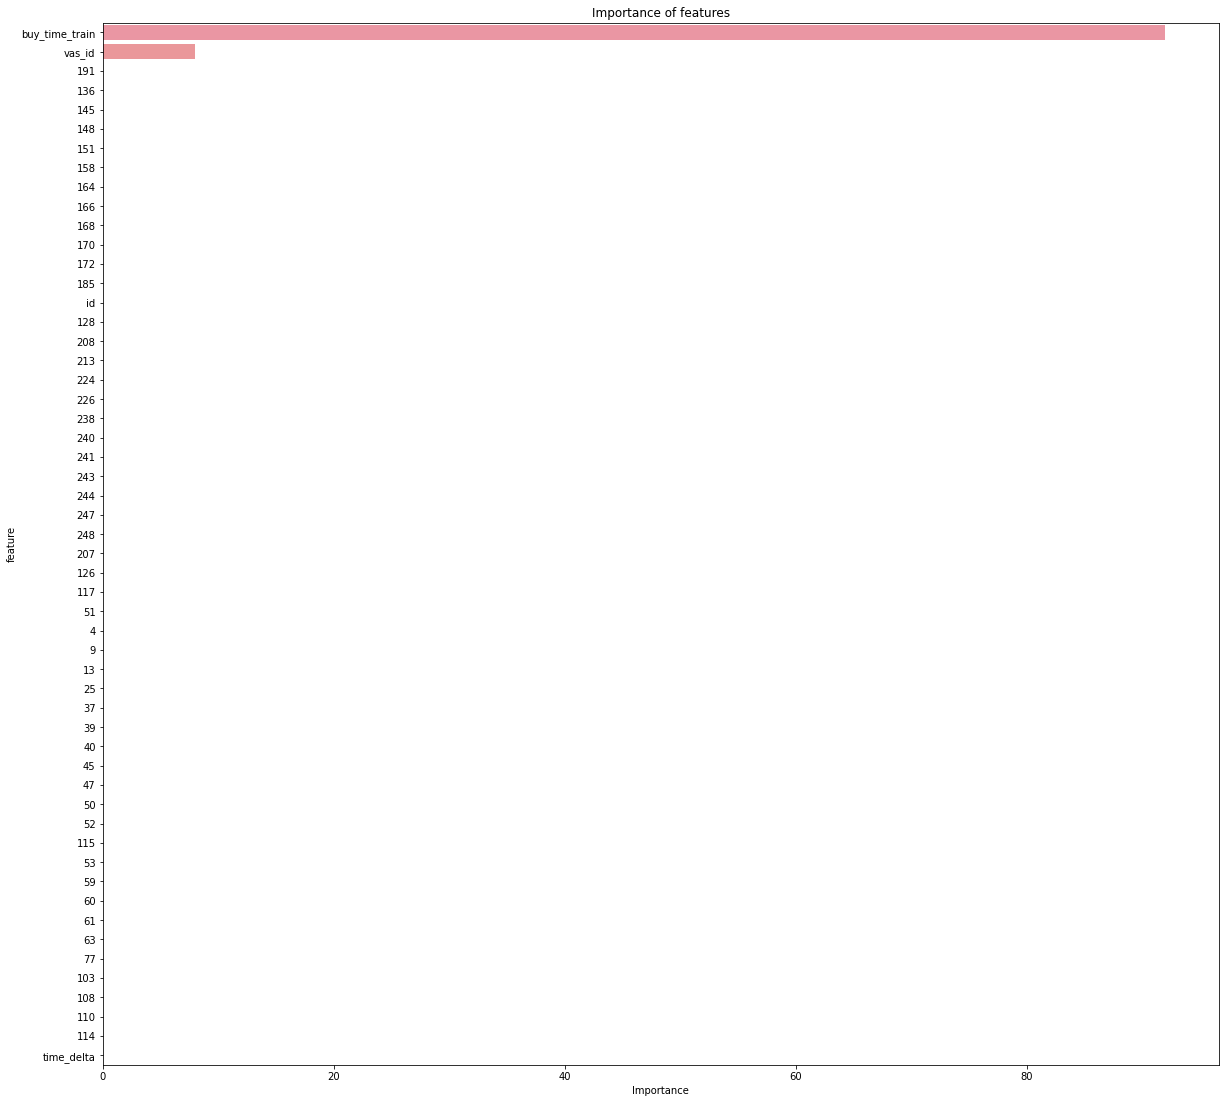

['buy_time_train',
 'vas_id',
 '191',
 '136',
 '145',
 '148',
 '151',
 '158',
 '164',
 '166']

In [83]:
show_feature_importances(feature_importances['feature_name'], feature_importances['importance'],\
                         get_top = 10)

In [84]:
best_fe = ['buy_time_train', 'vas_id']

SHAP

In [88]:
X_train['vas_id'] = X_train['vas_id'].astype('int8')
X_test['vas_id'] = X_test['vas_id'].astype('int8')

In [89]:
disbalance = y_train.value_counts()[0] / y_train.value_counts()[1]
frozen_params = {
 'class_weights':[1, disbalance], 
 'silent':True,
 'random_state':21,
 'cat_features': ['vas_id'],
 'eval_metric':'TotalF1',
 'early_stopping_rounds':40
}    
model_catb = catb.CatBoostClassifier(**frozen_params, iterations=300, max_depth=5)
model_catb.fit(X_train, y_train, plot=True, eval_set=(X_test, y_test))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [90]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model_catb)
shap_values = explainer.shap_values(X_train)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

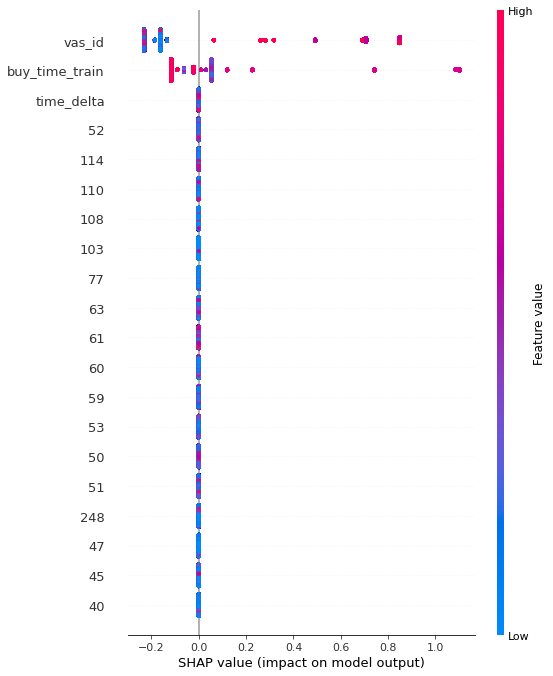

In [91]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_train)

Как его читать:

значения слева от центральной вертикальной линии — это negative класс (0), справа — positive (1)
чем толще линия на графике, тем больше таких точек наблюдения
чем краснее точка на графике, тем выше значения признака в ней

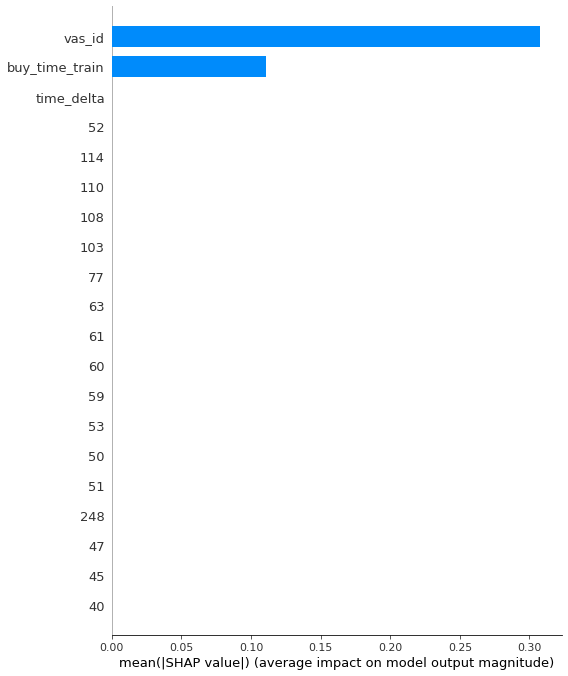

In [92]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

    Попытка вычленить нумерованные фичи не увенчалась успехом. Поэтому просто упакую эти фичи в  PCA.

#  Перезапускаю код

In [8]:
if 1:
    df_all = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ML_MEGAFON_CW/merged_train.csv')

In [9]:
if 0:
    df_all = pd.read_csv(data_folder.joinpath('merged_train.csv'))

In [9]:
X = df_all.drop(columns=['target'])
y = df_all['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    shuffle=True,
                                                    test_size=0.3,
                                                    random_state=21,
                                                    stratify=y)
train = pd.concat([X_train, y_train], axis = 1)
test = pd.concat([X_test, y_test], axis = 1)

In [10]:
del df_all

In [11]:
# Катбуст не принял категориальные фичи с другим типом
def convert_to_int(df, cat_feats):
    df[cat_feats] = df[cat_feats].astype('int8')
    
    return df

In [12]:
train = convert_to_int(train, ['vas_id'])
test = convert_to_int(test, ['vas_id'])

In [13]:
# time_delta оставлю для новых фичей
not_corr_feats = ['target', 'id', 'buy_time_train', 'vas_id', 'time_delta']

При таком раскладе с нумерованными признаками нет смысла возиться и даже их исследовать. Запакую их в PCA.

# Feature extraction

In [14]:
all_feats = train.columns.tolist()

In [15]:
corr_feats = [i for i in all_feats if i not in not_corr_feats]

In [16]:
len(corr_feats)

250

In [17]:
def my_scaler_fit(df, corr_feats):
    """Обучаю RobustScaler для стандартизации нумерованных фичей для упаковки в  PCA"""
    from sklearn.preprocessing import RobustScaler
    scaler = RobustScaler()
    scaler.fit(df[corr_feats])
    
    return scaler

In [18]:
help(my_scaler_fit)

Help on function my_scaler_fit in module __main__:

my_scaler_fit(df, corr_feats)
    Обучаю RobustScaler для стандартизации нумерованных фичей для упаковки в  PCA



In [19]:
scaler = my_scaler_fit(train, corr_feats)

In [20]:
def my_scaler_transform(df, scaler, corr_feats):
    """Преобразую RobustScaler_ом нумерованные фичи для упаковки в  PCA и показываю корреляцию этих фичей"""
    df=df.copy()
    df_norm = scaler.fit_transform(df[corr_feats])
    
    plt.figure(figsize = (15,10))
    sns.set(font_scale=1.4)
    corr_matrix = pd.DataFrame(df_norm).corr()
    corr_matrix = np.round(corr_matrix, 2)  # округлим до 2 знаков
    corr_matrix[np.abs(corr_matrix) < 0.5] = 0  # если корреляция меньше 0,3, то мы заменим на 0
    sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')
    plt.title('Correlation matrix')
    plt.show()
    
    df_1 = df[['target', 'id', 'buy_time_train', 'vas_id', 'time_delta']]
    df_1 = df_1.reset_index(drop=True)
    #df_norm = df_norm.reset_index(drop=True)
    df_norm = pd.DataFrame(df_norm, columns = corr_feats)
    df_scaled=pd.concat([df_1, df_norm], axis=1)
    
    return df_scaled

In [21]:
help(my_scaler_transform)

Help on function my_scaler_transform in module __main__:

my_scaler_transform(df, scaler, corr_feats)
    Преобразую RobustScaler_ом нумерованные фичи для упаковки в  PCA и показываю корреляцию этих фичей



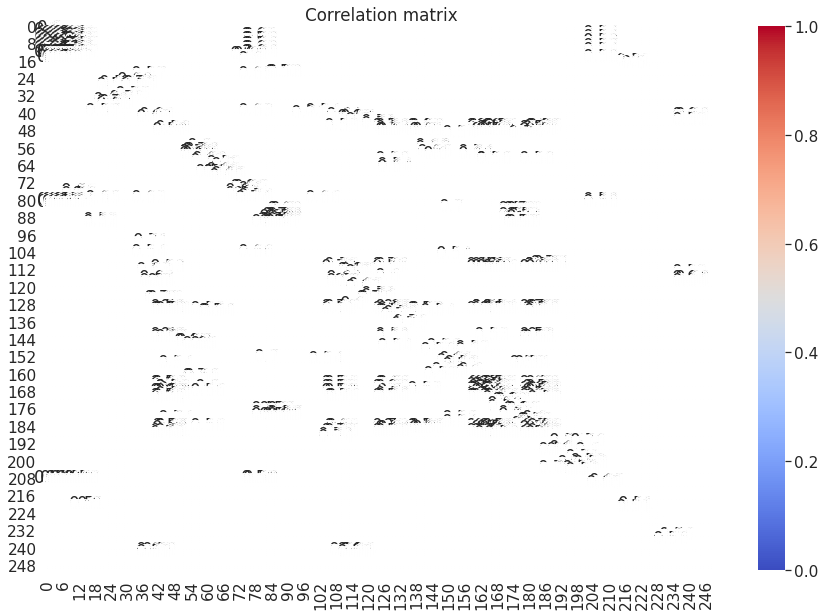

In [22]:
train = my_scaler_transform(train, scaler, corr_feats)

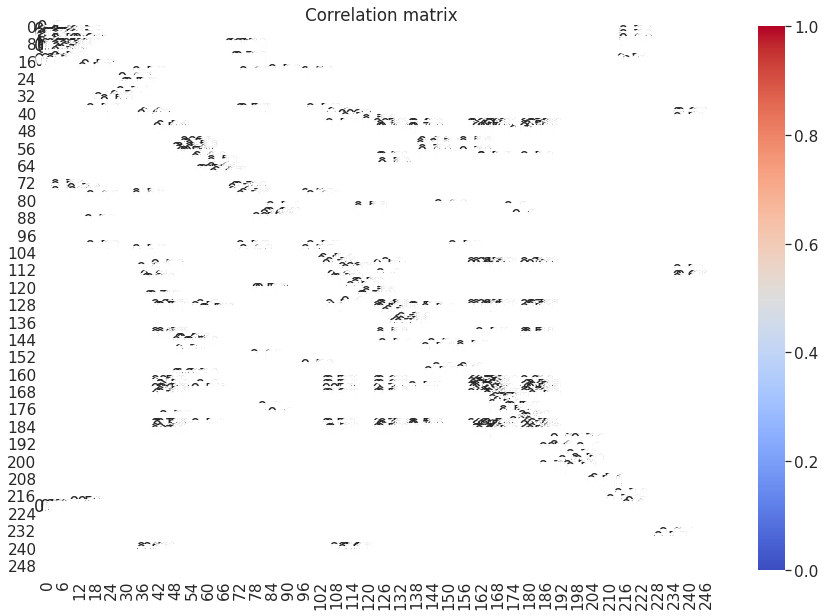

In [23]:
test = my_scaler_transform(test, scaler, corr_feats)

In [24]:
train.isna().sum().sum()

0

Снижение размерности до 3х компонент

In [25]:
def reduce_dims(df, dims=2, method='pca', perplexity=30):
    
    assert method in ['pca', 'tsne'], 'Неверно указан метод'
    
    if method=='pca':
        dim_reducer = PCA(n_components=dims, random_state=42)
        components = dim_reducer.fit_transform(df)
    elif method == 'tsne':
        dim_reducer = TSNE(n_components=dims, learning_rate=250, random_state=42, perplexity=perplexity)
        components = dim_reducer.fit_transform(df)
    else:
        print('Error')
        
    colnames = ['component_' + str(i) for i in range(1, dims+1)]
    return dim_reducer, pd.DataFrame(data = components, columns = colnames) 

In [26]:
def pca_fit_transform(train, corr_feats):
    """Функция сжимающая малозначимые признаки методом PCA и возвращающая кроме 
    обработанного датасета натренированную модель PCA"""
    dim_reducer3d, components_3d = reduce_dims(train[corr_feats], dims=3, method='pca')
    train_pca = pd.concat([train[['target', 'id', 'buy_time_train', 'vas_id', 'time_delta']], 
                           components_3d], axis=1)
    
    return train_pca, dim_reducer3d

In [27]:
train_pca, dim_reducer3d = pca_fit_transform(train, corr_feats)

In [28]:
def pca_transform(test, dim_reducer3d, corr_feats):
    """Функция сжимающая малозначимые признаки методом PCA на тестовой выборке"""
    dims = 3
    components = dim_reducer3d.transform(test[corr_feats])
    colnames = ['component_' + str(i) for i in range(1, dims+1)]
    components_3d_test = pd.DataFrame(data = components, columns = colnames)
    test_pca = pd.concat([test[['target', 'id', 'buy_time_train', 'vas_id', 'time_delta']],
                          components_3d_test], axis=1)
    
    return test_pca

In [29]:
test_pca = pca_transform(test, dim_reducer3d, corr_feats)

In [30]:
test_pca.isna().sum()

target            0
id                0
buy_time_train    0
vas_id            0
time_delta        0
component_1       0
component_2       0
component_3       0
dtype: int64

In [31]:
def display_components_in_3D_space(components_df, labels=None):
    components_with_labels_df = pd.concat([components_df, pd.DataFrame(labels)], axis=1)

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    
    if labels is not None:
        ax.scatter(components_with_labels_df['component_1'], 
                   components_with_labels_df['component_2'], 
                   components_with_labels_df['component_3'], 
                   c=components_with_labels_df.iloc[:, -1], 
                   cmap=plt.get_cmap('jet'), alpha=0.5)
    else:
        ax.scatter(components_with_labels_df['component_1'], 
                   components_with_labels_df['component_2'], 
                   components_with_labels_df['component_3'], 
                   alpha=0.5)

    ax.set_xlabel('component_1')
    ax.set_ylabel('component_2')
    ax.set_zlabel('component_3')
    plt.title('3D mapping of objects')
    plt.show()

In [32]:
train_pca.head()

,target,id,buy_time_train,vas_id,time_delta,component_1,component_2,component_3
0,0.0,253322,1541970000,4,6652800.0,-1.267103e+08,-88900.054239,-5003.774235
1,0.0,2983908,1534107600,1,1209600.0,-1.267103e+08,-88905.154629,-5003.457397
2,1.0,2031593,1543784400,6,604800.0,-1.267103e+08,-88900.053948,-5003.774410
3,1.0,97940,1544994000,6,3628800.0,-1.267103e+08,-88900.029431,-5003.800391
4,0.0,7923,1544994000,1,12700800.0,-1.267103e+08,-88900.050989,-5003.777742


In [33]:
components_df = train_pca[['component_1', 'component_2', 'component_3']]

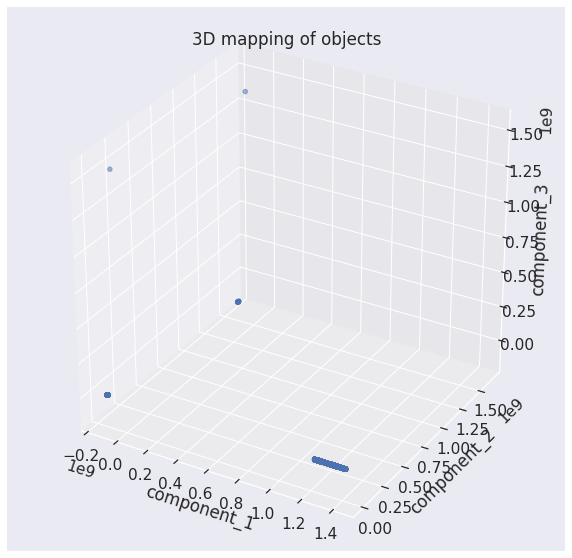

In [34]:
display_components_in_3D_space(components_df)

Четко видно 5 кластеров.

In [35]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=0).fit(components_df)
kmeans.labels_

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [36]:
np.unique(kmeans.labels_)

array([0, 1, 2, 3, 4], dtype=int32)

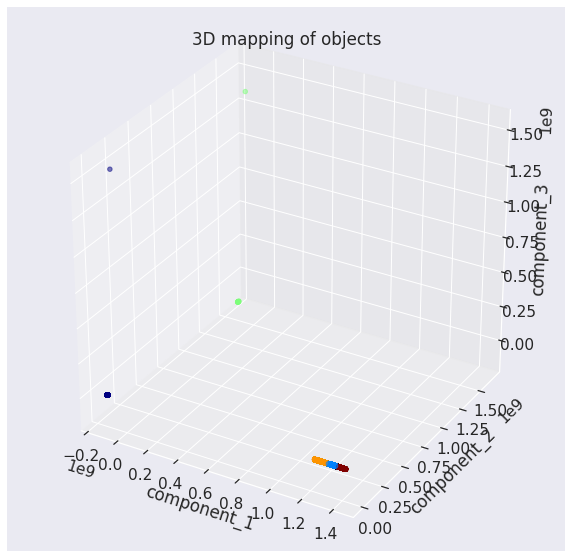

In [37]:
display_components_in_3D_space(components_df, kmeans.labels_)

In [38]:
components_df.shape

(286106, 3)

In [39]:
components_df = reduce_mem_usage(components_df)

Memory usage of dataframe is 6.55 MB
Memory usage after optimization is: 3.27 MB
Decreased by 50.0%



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [40]:
#from sklearn.cluster import AgglomerativeClustering
#clustering = AgglomerativeClustering(n_clusters=5).fit(df_agcl)
#clustering.labels_

In [41]:
#display_components_in_3D_space(df_agcl, clustering.labels_)

DBSCAN работает очень долго для этого проекта.

In [42]:
if 0:
    from sklearn.cluster import DBSCAN
    clustering = DBSCAN(eps=1, min_samples=5).fit(components_df)
    clustering.labels_

In [43]:
if 0:
    display_components_in_3D_space(components_df, clustering.labels_)

In [44]:
if 0:
    pd.DataFrame({'clasters':clustering.labels_}).to_csv('clasters.csv', index=False)

In [47]:
feature_importances = choise_features(train_pca, test_pca, ['vas_id'])

0.0    0.90925
1.0    0.09075
Name: target, dtype: float64

0.0    0.909255
1.0    0.090745
Name: target, dtype: float64

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN

              precision    recall  f1-score   support

         0.0       0.99      0.86      0.92    260142
         1.0       0.40      0.95      0.56     25964

    accuracy                           0.86    286106
   macro avg       0.69      0.90      0.74    286106
weighted avg       0.94      0.86      0.89    286106

TEST

              precision    recall  f1-score   support

         0.0       0.99      0.85      0.92    111491
         1.0       0.39      0.94      0.55     11127

    accuracy                           0.86    122618
   macro avg       0.69      0.90      0.74    122618
weighted avg       0.94      0.86      0.89    122618

CONFUSION MATRIX

col_0     0.0    1.0
target              
0.0     95246  16245
1.0       649  10478


In [48]:
train, test = train_pca, test_pca

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


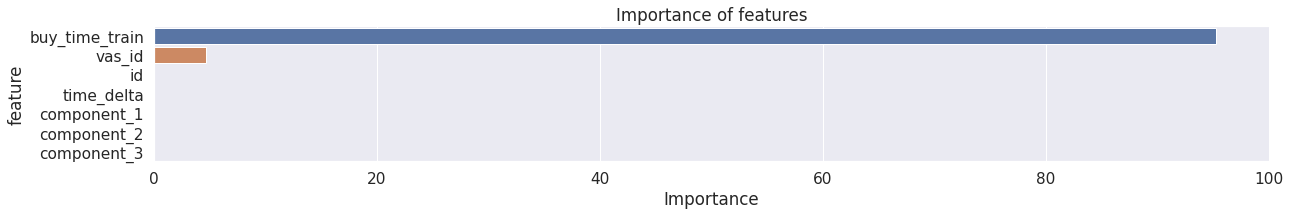

['buy_time_train',
 'vas_id',
 'id',
 'time_delta',
 'component_1',
 'component_2',
 'component_3']

In [49]:
show_feature_importances(feature_importances['feature_name'], feature_importances['importance'],\
                         get_top = 10)

По прежнему модель интересуют только 'buy_time_train' и 'vas_id'. SHAP_ом проверять нет смысла.

# Исследование компонентов.

component_1
ShapiroResult(statistic=0.3255387544631958, pvalue=0.0)


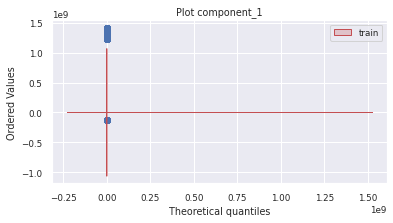

component_2
ShapiroResult(statistic=0.3138929605484009, pvalue=0.0)


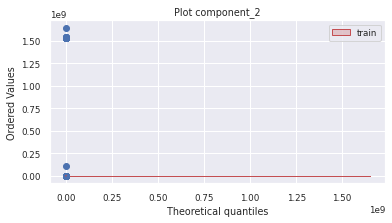

component_3
ShapiroResult(statistic=0.3200106620788574, pvalue=0.0)


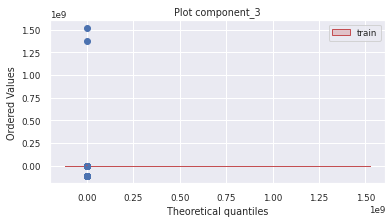

In [50]:
#Проверяю на нормальность методом Шапиро-Уилка и Куку-графиком 
figsize = (6, 3)
for col in ['component_1', 'component_2', 'component_3']:
    plt.figure(figsize=figsize)
    sns.set(font_scale=0.8)
    sns.kdeplot(train[col], shade=True, label='train', color='r')
    stats.probplot(train[col], dist='norm', plot=pylab)
    print(col)
    print(stats.shapiro(train[col].sample(5000)))
    plt.legend()
    plt.title(f'Plot {col}')
    plt.show()

component_1


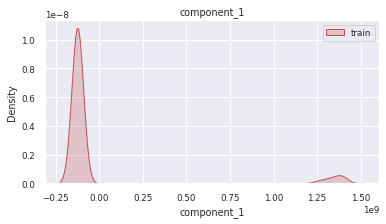

component_2


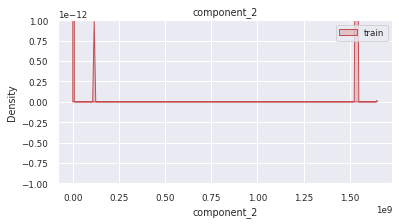

component_3


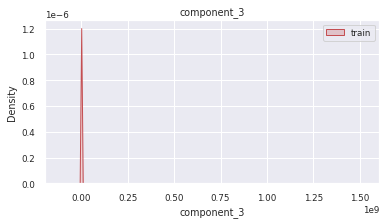

In [51]:
#Визуализирую полученные признаки
figsize = (6, 3)
for col in ['component_1', 'component_2', 'component_3']:
    plt.figure(figsize=figsize)
    sns.set(font_scale=0.8)
    sns.kdeplot(train[col], shade=True, label='train', color='r')
    print(col)
    plt.legend()
    plt.title(col)
    plt.show()

MannwhitneyuResult(statistic=39577.0, pvalue=0.6627231123388683)


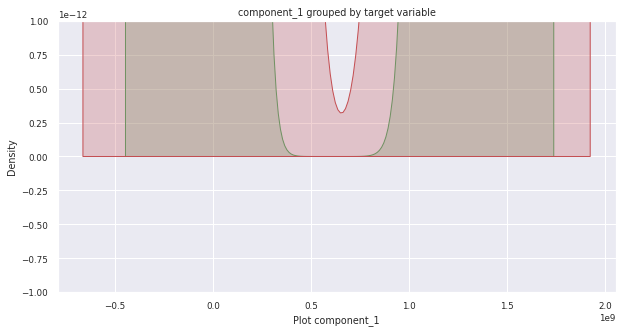

MannwhitneyuResult(statistic=35078.0, pvalue=0.7195318713983204)


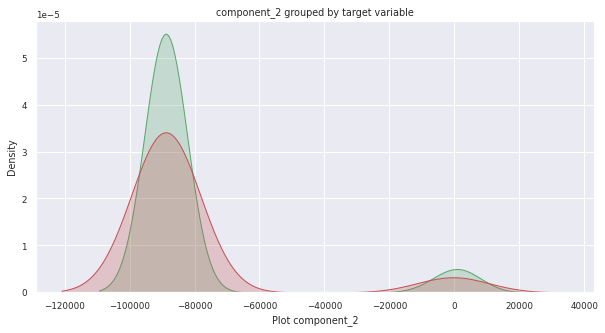

MannwhitneyuResult(statistic=37710.0, pvalue=0.5342549082305298)


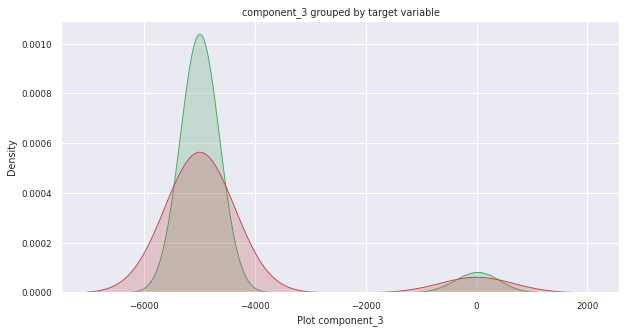

In [52]:
# проверка различий распределений фичей для target==0 и target==1.
for col in ['component_1', 'component_2', 'component_3']:
    age_with_target_s = pd.concat([train[col], train['target']], axis=1).sample(1000)
    age_s = age_with_target_s[col]
    age_target_0 = age_s[age_with_target_s['target'] == 0
    ]
    age_target_1 = age_s[age_with_target_s['target'] == 1
    ]
    print(stats.mannwhitneyu(age_target_0, age_target_1))
    plt.figure(figsize=(10, 5))

    sns.kdeplot(age_target_0, shade=True, label='0', color='g')
    sns.kdeplot(age_target_1, shade=True, label='1', color='r')

    plt.xlabel(f"Plot {col}")
    plt.title(f'{col} grouped by target variable')
    plt.show()

Отличия не большие.

component_1
MannwhitneyuResult(statistic=16436479708.0, pvalue=4.574899344048477e-224)


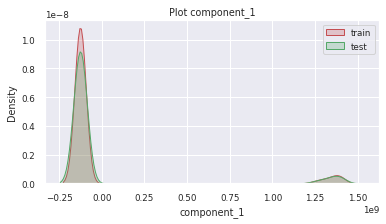

component_2
MannwhitneyuResult(statistic=17517104764.0, pvalue=0.4917136800036557)


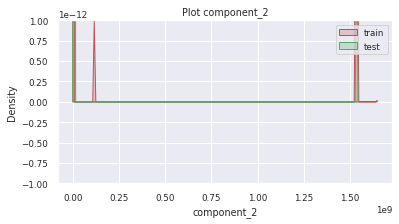

component_3
MannwhitneyuResult(statistic=17632741261.5, pvalue=0.007868285404394385)


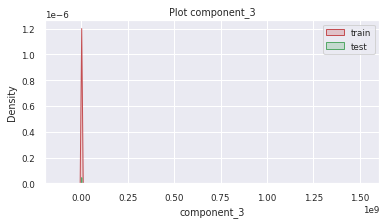

In [53]:
#Проверка соответствия признаков на трейне и на тесте

figsize = (6, 3)
for col in ['component_1', 'component_2', 'component_3']:
    plt.figure(figsize=figsize)
    sns.set(font_scale=0.8)
    sns.kdeplot(train[col], shade = True, label='train', color = 'r')
    sns.kdeplot(test[col], shade = True, label='test', color = 'g')
    print(col)
    print(stats.mannwhitneyu(train[col], test[col]))
    plt.legend()
    plt.title(f"Plot {col}")
    plt.show()

у component_2 разные распределения на трейне и на тесте. Такой признак может быть полезным при обучении на трейне, но на тесте он в таком случае приведет к ошибке удаляю его.

In [56]:
def drop_component_2(df):
    df.drop(columns=['component_2'], inplace=True)
    return df

In [57]:
train = drop_component_2(train)
test = drop_component_2(test)

У component_1 есть выбросы, но при почти нулевой значимости по метрике модели не определишь являются ли они на самом деле выбросами или нет. Поскольку мы строим модель для среднего пользователя стоило бы их убрать, но это сильно утяжелит модель при нулевом результате, не буду связываться.

# Обработка выбросов

Обработку выбросов перенес в ноутбук Feature_Engineering.ipynb